In [1]:
from tensorflow import keras

In [2]:
#download pre-trained model for detecting species
base_model = keras.applications.VGG16(
    weights = 'imagenet',
    input_shape = (224,224,3),
    include_top = False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
#freeze the base model so that training the Niko data will not affect the
#base model
base_model.trainable = False

In [4]:
#add trainable layers to the pre-trained model
inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
niko_model = keras.Model(inputs, outputs)
niko_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
#compile the model with binary crossentropy (Niko or not Niko)
niko_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])
              

In [6]:
#augment the provided images of Niko to prevent the model from simply
#memorizing the images of Niko provided
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    samplewise_center = True,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True)

In [7]:
#need to remove hidden directories
import os
import shutil

os.listdir("data/niko/train")

['niko', 'not_niko']

In [8]:
#shutil.rmtree("data/niko/train/.ipynb_checkpoints")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/niko/train/.ipynb_checkpoints'

In [ ]:
os.listdir("data/niko/valid")

In [ ]:
#shutil.rmtree("data/niko/valid/.ipynb_checkpoints")

In [9]:
#load training dataset
train_it = datagen.flow_from_directory('data/niko/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb',                                        
                                       class_mode='binary', 
                                       batch_size=8)

Found 125 images belonging to 2 classes.


In [10]:
#load validation dataset
valid_it = datagen.flow_from_directory('data/niko/valid/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 14 images belonging to 2 classes.


In [11]:
#train the niko model
niko_model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 36s 3s/step - loss: 0.3834 - binary_accuracy: 0.8280 - val_loss: 0.7418 - val_binary_accuracy: 0.7857
Epoch 2/20
12/12 [==============================] - 38s 3s/step - loss: 0.2361 - binary_accuracy: 0.9479
Epoch 3/20
12/12 [==============================] - 54s 4s/step - loss: 0.2905 - binary_accuracy: 0.9032
Epoch 4/20
12/12 [==============================] - 45s 4s/step - loss: 0.1195 - binary_accuracy: 0.9271
Epoch 5/20
12/12 [==============================] - 39s 3s/step - loss: 0.0823 - binary_accuracy: 0.9462
Epoch 6/20
12/12 [==============================] - 45s 4s/step - loss: 0.0909 - binary_accuracy: 0.9583
Epoch 7/20
12/12 [==============================] - 43s 4s/step - loss: 0.0328 - binary_accuracy: 0.9892
Epoch 8/20
12/12 [==============================] - 47s 4s/step - loss: 0.0169 - binary_accuracy: 1.0000
Epoch 9/20
12/12 [==============================] - 40s 3s/step - loss: 0.0212 - binary_accuracy: 1.0000
Epoch 

In [13]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
niko_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
niko_model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 122s 10s/step - loss: 2.3363e-04 - binary_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 102s 8s/step - loss: 0.0188 - binary_accuracy: 0.9892
Epoch 3/10
12/12 [==============================] - 145s 12s/step - loss: 0.0216 - binary_accuracy: 0.9896
Epoch 4/10
12/12 [==============================] - 139s 11s/step - loss: 2.6401e-07 - binary_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 180s 16s/step - loss: 6.1808e-07 - binary_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 90s 7s/step - loss: 3.4506e-06 - binary_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 52s 4s/step - loss: 2.7351e-06 - binary_accuracy: 1.0000
Epoch 8/10
12/12 [==============================] - 61s 5s/step - loss: 1.2388e-05 - binary_accuracy: 1.0000
Epoch 9/10
12/12 [==============================] - 89s 8s/step - loss: 3.6542e-07 - binary_accuracy: 1.0000
Epoch 10/10
12/12 

In [24]:
pip install playsound

  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7026 sha256=ba2c1cbdda21a4992a25691e6f99b2d486c9fdd2b5ae52eec144bf645c4eb76e
  Stored in directory: c:\users\sophi\appdata\local\pip\cache\wheels\73\cd\cf\9750b618d54bd81c20e4c34fb24a423a5b095920367cdb3f71
Successfully built playsound
Note: you may need to restart the kernel to use updated packages.


In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from playsound import playsound

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = niko_model.predict(image)
    return preds

In [26]:
def niko_approaching(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("THIS IS NOT YOUR FOOD!!")
        playsound("sounds_that_scare_cats.mp3")
    else:
        print("NOT NIKO")

In [ ]:
niko_approaching('data/niko/valid/niko/IMG_2652.JPG')

THIS IS NOT YOUR FOOD!!


NOT NIKO


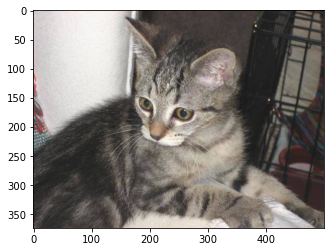

In [22]:
niko_approaching('data/niko/valid/not_niko/122.JPG')